In [1]:
import pandas as pd

In [2]:
file = ('experience-of-sexual-violence.csv')
data = pd.read_csv(file)
df = (data.rename(columns={

        'Particulars of the Background Characteristic': 'particulars',
        
        'Women:Percentage who have experienced sexual violence (ever)': 'w_life',

        'Women:Percentage who have experienced sexual violence (Past 12 months)': 'w_past12',

        'Women: Number of Women': 'women_total',

        'Men:Percentage who have experienced sexual violence (ever)': 'm_life',

        'Men:Percentage who have experienced sexual violence (Past 12 months)': 'm_past12',

        'Men: Number of Men': 'men_total'
    })
)
#.drop(columns=data.columns[-1])

df

,Period,background,particulars,w_life,w_past12,women_total,m_life,m_past12,men_total
0,UDHS 2016,Age,15-19,9.9,5.3,"2,090",4.6,1.3,867
1,UDHS 2016,Age,20-24,19.9,13.9,"1,952",9.4,3.4,701
2,UDHS 2016,Age,25-29,25.1,15.8,"1,477",10.0,4.7,568
3,UDHS 2016,Age,30-39,28.7,16.2,"2,301",9.8,6.2,933
4,UDHS 2016,Age,40-49,28.2,13.2,"1,412",8.4,4.6,690
...,...,...,...,...,...,...,...,...,...
143,UDHS 2006,Wealth quintile,Fourth,40.3,NaN,422,16.9,NaN,368
144,UDHS 2006,Wealth quintile,Highest,33.8,NaN,509,10.7,NaN,449
145,UDHS 2006,Total,Total 15-49,39,NaN,"2,087",10.9,NaN,"1,764"
146,UDHS 2006,Total,Men 50-54,na,NaN,na,17.8,NaN,80


#### Cleaning numeric columns by removing quotes, commas, getting rid of -ve sign, and converting into float

Columns that are 'object' type and contain commas/quotes

In [3]:
cols_to_clean = []

for col in df.select_dtypes(include=['object']).columns:
    sample_values = df[col].dropna().astype(str).tolist()
    
    needs_cleaning = False
    for val in sample_values:
        if ',' in val or '"' in val or "'" in val:
            needs_cleaning = True
            break
            
    if needs_cleaning:
        cols_to_clean.append(col)
        
print("Columns that are 'object' type and contain commas/quotes in the sample data:")
print(cols_to_clean)

Columns that are 'object' type and contain commas/quotes in the sample data:
['women_total', 'men_total']


In [4]:
if cols_to_clean:
    print("\nSample values from these columns for verification:")
    for col in cols_to_clean:
        print(f"-- {col} --")
        
        print(df[col].dropna().tail().to_string(index=False))


Sample values from these columns for verification:
-- women_total --
  422
  509
2,087
   na
   na
-- men_total --
  368
  449
1,764
   80
1,844


In [5]:
numerical_cols = ['w_life', 'w_past12', 'women_total', 'm_life', 'm_past12', 'men_total']

for col in numerical_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.replace(r'[" ,]', '', regex=True)
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

##### Treating columns with negative values, 1st anomaly detected(Negative Values)

In [6]:
negative_counts = {}
for _ in numerical_cols:
    # to check only if the column is numeric
    if pd.api.types.is_numeric_dtype(df[_]):
        count = (df[_] < 0).sum()
        if count > 0:
            negative_counts[_] = count

if negative_counts:
    print(f"\nNegative figures found in the following columns (Count of negative rows):")
    print(negative_counts)
else:
    print("\nNo negative figures detected in the numerical columns.")


Negative figures found in the following columns (Count of negative rows):
{'w_past12': np.int64(1), 'm_life': np.int64(1), 'm_past12': np.int64(1)}


In [7]:
import numpy as np

In [8]:
df[numerical_cols] = df[numerical_cols].abs()

neg_nums = (df.select_dtypes(include=[np.number]) < 0)

print(df[neg_nums.any(axis=1)])

Empty DataFrame
Columns: [Period, background, particulars, w_life, w_past12, women_total, m_life, m_past12, men_total]
Index: []


Z-Score method 

In [9]:
from scipy import stats

In [10]:
# to fill NaNs with median
X = df[numerical_cols].copy()
X = X.fillna(X.median())

In [11]:
z_thresh = 3.0
z_scores = df[numerical_cols].apply(lambda x: np.abs(stats.zscore(x, nan_policy='omit')))
z_anoms = (z_scores > z_thresh)
z_any = z_anoms.any(axis=1)

df['_z_anomaly'] = z_any.astype(int)

print(f"\nZ-score anomalies flagged (threshold={z_thresh}): {df['_z_anomaly'].sum()} rows")


Z-score anomalies flagged (threshold=3.0): 8 rows


In [12]:
from sklearn.ensemble import IsolationForest

In [13]:
iso = IsolationForest(n_estimators=200, contamination='auto', random_state=42)
iso_preds = iso.fit_predict(X)  # -1 for anomaly, 1 for normal
df['_iso_anomaly'] = (iso_preds == -1).astype(int)
print("IsolationForest anomalies flagged:", df['_iso_anomaly'].sum())

IsolationForest anomalies flagged: 19


In [14]:
# a combined anomally flag
df['_anomaly_any'] = ((df['_z_anomaly'] == 1) | (df['_iso_anomaly'] == 1)).astype(int)
print("Combined anomalies (z-score OR IsolationForest):", df['_anomaly_any'].sum())

Combined anomalies (z-score OR IsolationForest): 20


In [15]:
# a distribution of Anomaly Flags
print("--- Anomaly Flag Counts ---")
print("Total rows with ANY anomaly flagged:")
print(df['_anomaly_any'].value_counts())
print("\n")

--- Anomaly Flag Counts ---
Total rows with ANY anomaly flagged:
_anomaly_any
0    128
1     20
Name: count, dtype: int64




#### Visualisation of anomalies from Z-Score & Isolation Forest

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

Heatmap of Anomaly flags across the whole dataset

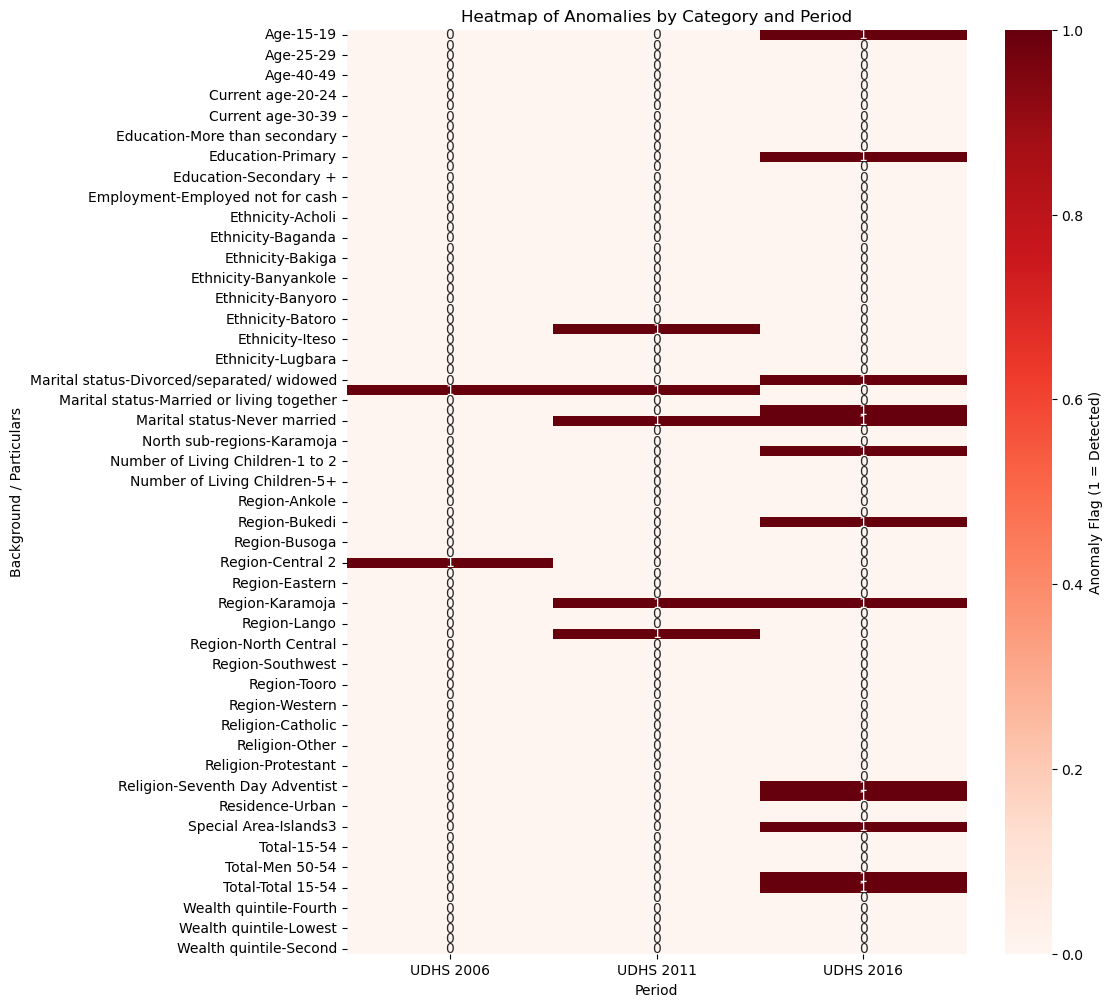

In [17]:
# a pivot for heatmap: rows as particulars/background, columns as periods/anomaly types
anomaly_cols = ['Period', 'background', 'particulars', '_z_anomaly', '_iso_anomaly', '_anomaly_any']
pivot_df = df[anomaly_cols].pivot_table(index=['background', 'particulars'], columns='Period', values='_anomaly_any', fill_value=0)

# heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(pivot_df, annot=True, cmap='Reds', cbar_kws={'label': 'Anomaly Flag (1 = Detected)'})
plt.title('Heatmap of Anomalies by Category and Period')
plt.xlabel('Period')
plt.ylabel('Background / Particulars')
plt.show()

Box Plot for Distribution and Outliers - Prevalence by Gender/Period

<Figure size 1500x500 with 0 Axes>

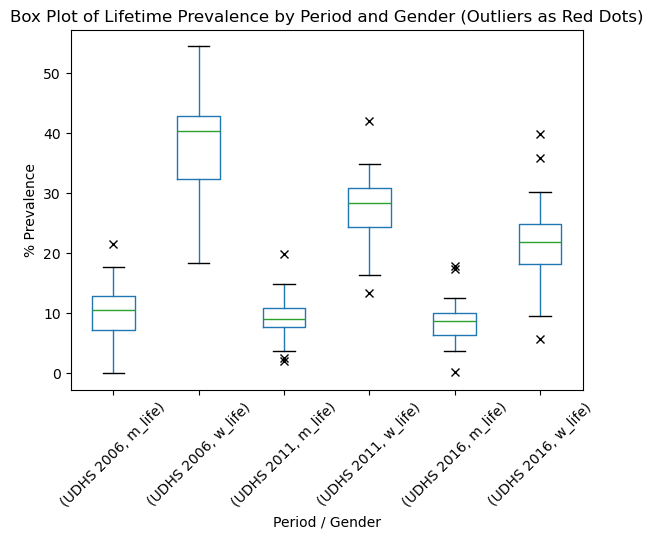

In [18]:
# to melt data for boxplot: focus on lifetime prevalence
melted = pd.melt(df, id_vars=['Period'], value_vars=['w_life', 'm_life'], var_name='Gender', value_name='Prevalence')
melted = melted[melted['Prevalence'].notna()]

# boxplot
plt.figure(figsize=(15, 5))
melted.boxplot(column='Prevalence', by=['Period', 'Gender'], grid=False, showfliers=True, flierprops={'marker': 'x', 'color': 'red'})
plt.title('Box Plot of Lifetime Prevalence by Period and Gender (Outliers as Red Dots)')
plt.suptitle('')
plt.xlabel('Period / Gender')
plt.ylabel('% Prevalence')
plt.xticks(rotation=45)
plt.show()

Scatter Plot for Multivariate Anomalies - Lifetime vs. Past-12 for Women

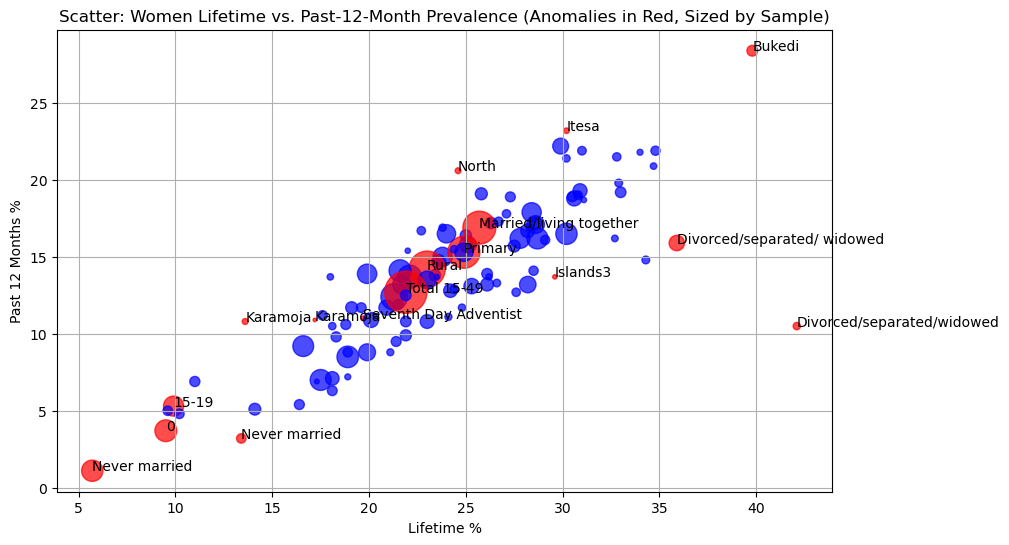

In [19]:
# to filter non-NaN and plot
plot_df = df[df['w_life'].notna() & df['w_past12'].notna()]

# to color by anomaly, size by sample
colors = ['red' if row['_anomaly_any'] == 1 else 'blue' for _, row in plot_df.iterrows()]
sizes = plot_df['women_total'] / 10  # to scale for visibility

plt.figure(figsize=(10, 6))
plt.scatter(plot_df['w_life'], plot_df['w_past12'], c=colors, s=sizes, alpha=0.7)
plt.title('Scatter: Women Lifetime vs. Past-12-Month Prevalence (Anomalies in Red, Sized by Sample)')
plt.xlabel('Lifetime %')
plt.ylabel('Past 12 Months %')
plt.grid(True)
# to annotate key points
for i, row in plot_df.iterrows():
    if row['_anomaly_any'] == 1:
        plt.annotate(row['particulars'], (row['w_life'], row['w_past12']))
plt.show()

Scatter Plot for Multivariate Anomalies - Lifetime vs. Past-12 for Men

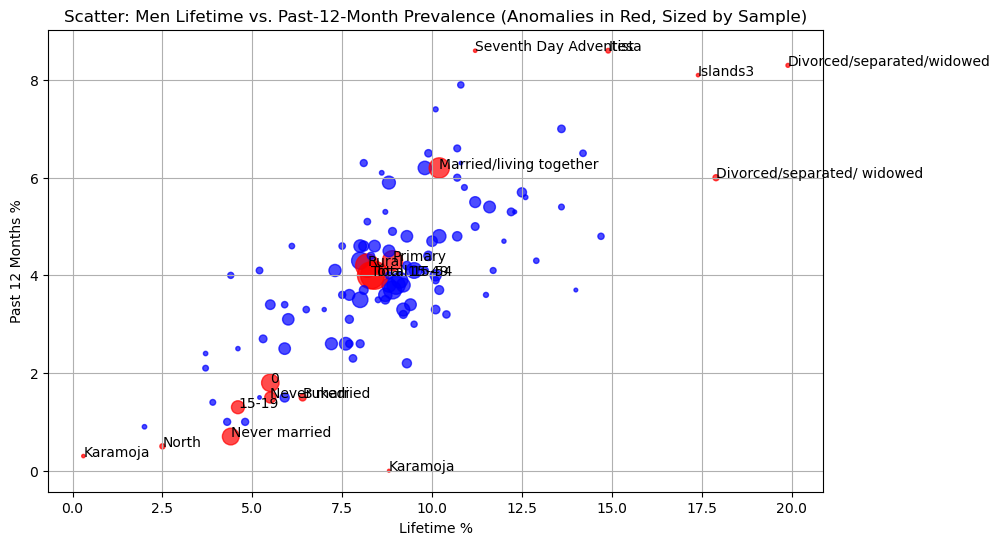

In [20]:
# to filter non-NaN and plot
plot_df = df[df['m_life'].notna() & df['m_past12'].notna()]

# to color by anomaly, size by sample
colors = ['red' if row['_anomaly_any'] == 1 else 'blue' for _, row in plot_df.iterrows()]
sizes = plot_df['men_total'] / 10  # to scale for visibility

plt.figure(figsize=(10, 6))
plt.scatter(plot_df['m_life'], plot_df['m_past12'], c=colors, s=sizes, alpha=0.7)
plt.title('Scatter: Men Lifetime vs. Past-12-Month Prevalence (Anomalies in Red, Sized by Sample)')
plt.xlabel('Lifetime %')
plt.ylabel('Past 12 Months %')
plt.grid(True)
# to annotate key points
for i, row in plot_df.iterrows():
    if row['_anomaly_any'] == 1:
        plt.annotate(row['particulars'], (row['m_life'], row['m_past12']))
plt.show()

In [ ]:
# plt.savefig('filename.png')

In [21]:
#df.to_csv('experience-of-sexual-violence-.csv', index=False, encoding='utf-8')

In [22]:
# okotpascal5@gmail.com --- https://github.com/OkotPascal --- https://www.linkedin.com/in/okot-pascal-a98251235/